In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as img
import numpy as np
import os
import pandas as pd
import pickle
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,Conv2D
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D, AveragePooling2D, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.keras.optimizers import SGD,Adam
from tensorflow.keras.regularizers import l2
from tensorflow import keras
import numpy as np
from sklearn.metrics import classification_report,confusion_matrix
from tensorflow.keras.applications import MobileNetV2
from sklearn.metrics import precision_score, recall_score, f1_score
from tensorflow.keras import metrics
import seaborn as sns
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.callbacks import Callback
from datetime import datetime

# Data Processing

In [2]:
num_classes = 251

width, height = 224, 224

train_dir = '/kaggle/input/ifood-2019/ifood-2019-fgvc6/organized_train_set'

val_dir = '/kaggle/input/ifood-2019/ifood-2019-fgvc6/organized_val_set'

test_dir = '/kaggle/input/ifood-2019/ifood-2019-fgvc6/test_set'

batch_size = 32

In [3]:
train_datagen = ImageDataGenerator(

    rescale=1. / 255,

    shear_range=0.2,

    rotation_range=30,

    width_shift_range=0.2,

    height_shift_range=0.2,

    zoom_range=0.2,

    horizontal_flip=True,

)



validation_datagen = ImageDataGenerator(rescale=1. / 255)

In [4]:
train_set = train_datagen.flow_from_directory(

    train_dir,

    target_size=(width, height),

    batch_size=batch_size,

    class_mode='categorical',

)



val_set = validation_datagen.flow_from_directory(

    val_dir,

    target_size=(width, height),

    batch_size=batch_size,

    shuffle=False,

    class_mode='categorical',

)

Found 118475 images belonging to 251 classes.
Found 11994 images belonging to 251 classes.


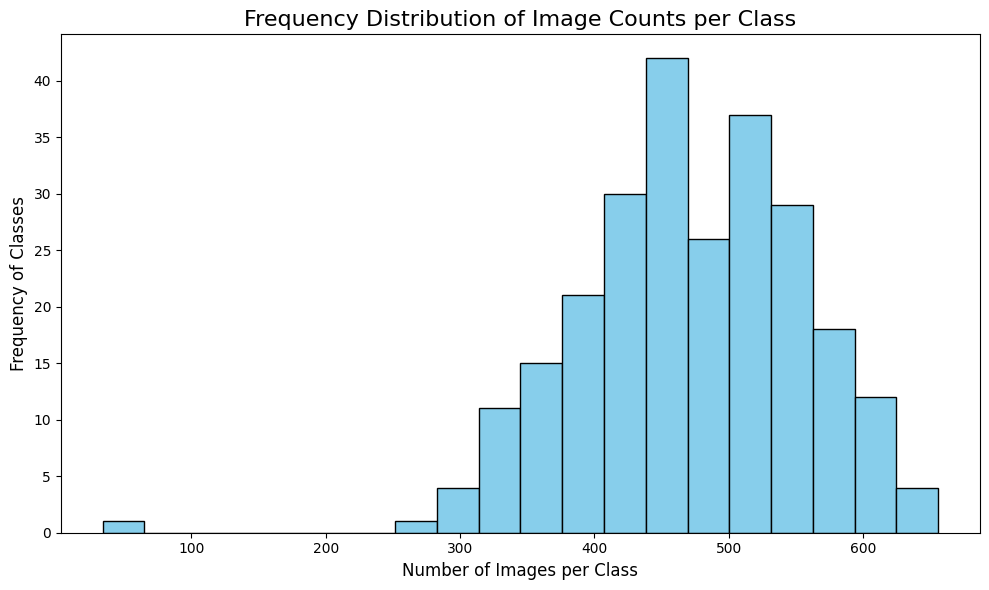

In [5]:
# Get a list of all class directories

class_dirs = [d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))]



# Count the number of images in each class directory

class_counts = [len(os.listdir(os.path.join(train_dir, cls))) for cls in class_dirs]



# Plot the frequency of image counts using a histogram

plt.figure(figsize=(10, 6))

plt.hist(class_counts, bins=20, color='skyblue', edgecolor='black')



plt.title('Frequency Distribution of Image Counts per Class', fontsize=16)

plt.xlabel('Number of Images per Class', fontsize=12)

plt.ylabel('Frequency of Classes', fontsize=12)



plt.tight_layout()



# Display the frequency chart

plt.show()




In [6]:
from sklearn.utils import class_weight



class_labels = train_set.classes  # Labels for each image in the training set



# Compute class weights

class_weights = class_weight.compute_class_weight(class_weight='balanced',

                                                  classes=np.unique(class_labels),

                                                  y=class_labels)



# Keras requires dict format

class_weights_dict = dict(enumerate(class_weights))



print("Class Weights:", class_weights_dict)


Class Weights: {0: 0.7456744900335467, 1: 0.8822653311985702, 2: 1.3882704476212795, 3: 1.1002609608187297, 4: 0.8956583533040513, 5: 0.8724805031261277, 6: 1.5733731739707835, 7: 1.0283484797194664, 8: 1.0000253224390574, 9: 0.9613278048701325, 10: 0.9346771330519507, 11: 1.0465896944373283, 12: 1.0238870980287094, 13: 0.8194651947764497, 14: 1.1028316639982128, 15: 0.9237024504720842, 16: 0.9007861683038837, 17: 1.0875851432977766, 18: 0.9874727033289437, 19: 0.8194651947764497, 20: 0.9440239043824701, 21: 0.7650112677329579, 22: 0.816629675071341, 23: 0.7712613597895998, 24: 0.7788976108766255, 25: 0.839878918489742, 26: 1.151248663881061, 27: 1.0150794670779248, 28: 0.89736112583885, 29: 0.8773456360431878, 30: 1.0727544367982615, 31: 0.9237024504720842, 32: 1.0351139302439365, 33: 1.279165182090068, 34: 0.8295464889125397, 35: 1.1106163580970236, 36: 0.9025085127939485, 37: 1.0776528588840983, 38: 1.0064220729024203, 39: 1.1158674992700592, 40: 1.2041121229368241, 41: 1.0776528588

# Model Callbacks

In [5]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau



checkpoint_dir = '/kaggle/working/PreTrained_Model_Tests/NoWeights'

os.makedirs(checkpoint_dir, exist_ok=True)


timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")

# Callbacks
Callbacks = [
    ModelCheckpoint(filepath=os.path.join(checkpoint_dir, f'Densenet201_NoWeight_Best_{timestamp}.keras'),
                    save_best_only=True,
                    monitor='val_loss',
                    mode='min',
                    verbose=1),  # Save the best model based on validation loss
    EarlyStopping(monitor='val_loss',
                  patience=10,  # Stop training after 10 epochs without improvement
                  mode='min',
                  verbose=1,
                  restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss',
                      factor=0.2,  # Reduce learning rate by 20%
                      patience=3,  # Reduce if no improvement after 3 epochs
                      mode='min',
                      verbose=1),
]

In [6]:
from keras.callbacks import Callback
from datetime import datetime

class SaveHistory(Callback):

    def __init__(self, save_path):

        super(SaveHistory, self).__init__()

        self.save_path = save_path

        # Load history if exists
        if os.path.exists(self.save_path):

            with open(self.save_path, 'rb') as f:
                self.history = pickle.load(f)

        else:
            self.history = {'accuracy': [], 'val_accuracy': [], 'loss': [], 'val_loss': [], 'precision': [], 'val_precision': [], 'recall': [], 'val_recall': []}

    def on_epoch_end(self, epoch, logs=None):
        # Append new logs to the existing history
        self.history['accuracy'].append(logs.get('accuracy'))
        self.history['val_accuracy'].append(logs.get('val_accuracy'))
        self.history['loss'].append(logs.get('loss'))
        self.history['val_loss'].append(logs.get('val_loss'))
        self.history['precision'].append(logs.get('precision'))
        self.history['val_precision'].append(logs.get('val_precision'))
        self.history['recall'].append(logs.get('recall'))
        self.history['val_recall'].append(logs.get('val_recall'))

        # Create directory if it doesn't exist
        os.makedirs(os.path.dirname(self.save_path), exist_ok=True)
        
        # Save history to a file
        with open(self.save_path, 'wb') as f:
            pickle.dump(self.history, f)

        print(f"Epoch {epoch+1} history saved to {self.save_path}")

# Create a unique filename with a timestamp
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
history_save_path = f'/kaggle/working/PreTrained_Model_Data/Densenet201_NoWeights_train_history_{timestamp}.pkl'

# Create the callback
history_callback = SaveHistory(save_path=history_save_path)


# DenseNet201 Testing

In [7]:
resnet = tf.keras.applications.DenseNet201(weights='imagenet', include_top=False,input_shape=(width,width,3))
for layer in resnet.layers[:150]:
     layer.trainable=False

74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [8]:
x = resnet.output

x = GlobalAveragePooling2D()(x)

x = Dense(300,activation='relu')(x)

x = Dropout(0.5)(x)

output = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=resnet.input, outputs=output)

model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy', 
                metrics.Precision(name='precision'), metrics.Recall(name='recall')])

history = model.fit(train_set,

        validation_data = val_set,

        epochs=20,

        verbose=1,

        #class_weight= class_weights_dict,

        callbacks=[Callbacks, history_callback]

         )

Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1733055975.154901     116 service.cc:145] XLA service 0x7c38a4001560 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733055975.154962     116 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1733056061.074133     116 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_fusion_40', 20 bytes spill stores, 20 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_fusion_39', 24 bytes spill stores, 44 byte

 742/3703 ━━━━━━━━━━━━━━━━━━━━ 21:45 441ms/step - accuracy: 0.0235 - loss: 5.4367 - precision: 0.2797 - recall: 2.7423e-04

I0000 00:00:1733056466.462870     116 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_fusion_12', 8 bytes spill stores, 48 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_6', 4 bytes spill stores, 28 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_7', 8 bytes spill stores, 44 bytes spill loads



3703/3703 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step - accuracy: 0.1148 - loss: 4.6352 - precision: 0.5791 - recall: 0.0243

I0000 00:00:1733057845.510783     116 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_5', 8 bytes spill stores, 8 bytes spill loads




Epoch 1: val_loss improved from inf to 2.22062, saving model to /kaggle/working/PreTrained_Model_Tests/NoWeights/Densenet201_NoWeight_Best_20241201-122427.keras


I0000 00:00:1733057920.280086     114 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_5', 8 bytes spill stores, 8 bytes spill loads



Epoch 1 history saved to /kaggle/working/PreTrained_Model_Data/Densenet201_NoWeights_train_history_20241201_122440.pkl
3703/3703 ━━━━━━━━━━━━━━━━━━━━ 2001s 503ms/step - accuracy: 0.1149 - loss: 4.6351 - precision: 0.5791 - recall: 0.0243 - val_accuracy: 0.4875 - val_loss: 2.2206 - val_precision: 0.7972 - val_recall: 0.2665 - learning_rate: 1.0000e-04
Epoch 2/20
3703/3703 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step - accuracy: 0.3587 - loss: 2.9410 - precision: 0.7193 - recall: 0.1755
Epoch 2: val_loss improved from 2.22062 to 1.87844, saving model to /kaggle/working/PreTrained_Model_Tests/NoWeights/Densenet201_NoWeight_Best_20241201-122427.keras
Epoch 2 history saved to /kaggle/working/PreTrained_Model_Data/Densenet201_NoWeights_train_history_20241201_122440.pkl
3703/3703 ━━━━━━━━━━━━━━━━━━━━ 1471s 396ms/step - accuracy: 0.3587 - loss: 2.9410 - precision: 0.7193 - recall: 0.1755 - val_accuracy: 0.5475 - val_loss: 1.8784 - val_precision: 0.7793 - val_recall: 0.3854 - learning_rate: 1.0000e-04
Ep

In [ ]:
model.summary()

In [ ]:
# Evaluate the model

score = model.evaluate(val_set, verbose=1)

print("\nTest accuracy:", score[1])

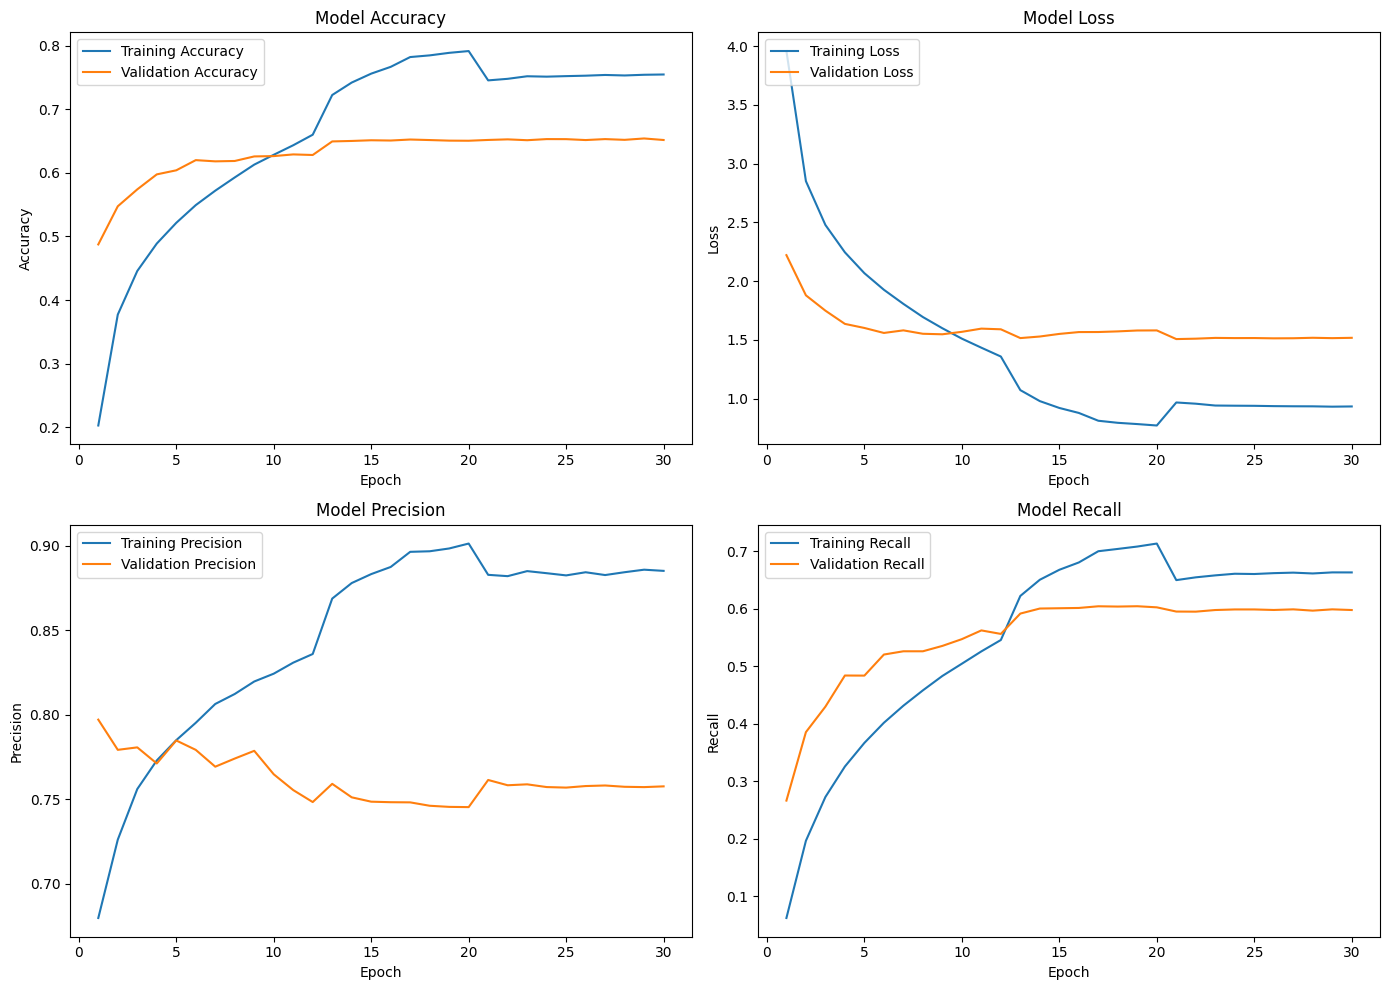

In [11]:
# Load the history from the first file
with open('/kaggle/working/PreTrained_Model_Data/Densenet201_NoWeights_train_history_20241201_122440.pkl', 'rb') as file:
    history1 = pickle.load(file)

# Load the history from the second file
with open('/kaggle/working/PreTrained_Model_Data/Densenet201_NoWeights_train_history_20241202_020410.pkl', 'rb') as file: 
    history2 = pickle.load(file)

# Combine metrics for all keys in the history
combined_history = {}
for key in history1:
    combined_history[key] = history1[key] + history2[key]

# Define combined epochs
total_epochs = len(combined_history['loss'])
epochs = np.arange(1, total_epochs + 1)

# Set up a larger figure with 2 rows and 2 columns
plt.figure(figsize=(14, 10))

# Plot training & validation accuracy
plt.subplot(2, 2, 1)
plt.plot(epochs, combined_history['accuracy'], label='Training Accuracy')
plt.plot(epochs, combined_history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

# Plot training & validation loss
plt.subplot(2, 2, 2)
plt.plot(epochs, combined_history['loss'], label='Training Loss')
plt.plot(epochs, combined_history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

# Plot training & validation precision
plt.subplot(2, 2, 3)
plt.plot(epochs, combined_history['precision'], label='Training Precision')
plt.plot(epochs, combined_history['val_precision'], label='Validation Precision')
plt.title('Model Precision')
plt.ylabel('Precision')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

# Plot training & validation recall
plt.subplot(2, 2, 4)
plt.plot(epochs, combined_history['recall'], label='Training Recall')
plt.plot(epochs, combined_history['val_recall'], label='Validation Recall')
plt.title('Model Recall')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()


In [5]:
loaded_model = tf.keras.models.load_model('/kaggle/working/PreTrained_Model_Tests/NoWeights/Densenet201_NoWeight_Best_20241201-122427.keras')

In [8]:
loaded_model.compile(optimizer=Adam(learning_rate=0.0000008), loss='categorical_crossentropy', metrics=['accuracy', 
                metrics.Precision(name='precision'), metrics.Recall(name='recall')])

history =loaded_model.fit(train_set,

        validation_data = val_set,

        epochs=10,

        verbose=1,

        #class_weight= class_weights_dict,

        callbacks=[Callbacks, history_callback]

         )

Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1733105298.301739     116 service.cc:145] XLA service 0x7aa3ac004340 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733105298.301807     116 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1733105376.599313     116 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_fusion_40', 20 bytes spill stores, 20 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_fusion_39', 24 bytes spill stores, 44 byte

2228/3703 ━━━━━━━━━━━━━━━━━━━━ 13:44 559ms/step - accuracy: 0.7434 - loss: 0.9759 - precision: 0.8835 - recall: 0.6458

I0000 00:00:1733106695.601497     115 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_fusion_12', 8 bytes spill stores, 48 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_6', 4 bytes spill stores, 28 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_7', 8 bytes spill stores, 44 bytes spill loads



3703/3703 ━━━━━━━━━━━━━━━━━━━━ 0s 577ms/step - accuracy: 0.7440 - loss: 0.9730 - precision: 0.8832 - recall: 0.6469

I0000 00:00:1733107527.405946     115 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_5', 8 bytes spill stores, 8 bytes spill loads




Epoch 1: val_loss improved from inf to 1.50594, saving model to /kaggle/working/PreTrained_Model_Tests/NoWeights/Densenet201_NoWeight_Best_20241202-020406.keras


I0000 00:00:1733107639.696280     116 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_5', 8 bytes spill stores, 8 bytes spill loads



Epoch 1 history saved to /kaggle/working/PreTrained_Model_Data/Densenet201_NoWeights_train_history_20241202_020410.pkl
3703/3703 ━━━━━━━━━━━━━━━━━━━━ 2395s 612ms/step - accuracy: 0.7440 - loss: 0.9730 - precision: 0.8832 - recall: 0.6469 - val_accuracy: 0.6519 - val_loss: 1.5059 - val_precision: 0.7615 - val_recall: 0.5950 - learning_rate: 8.0000e-07
Epoch 2/10
3703/3703 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step - accuracy: 0.7491 - loss: 0.9542 - precision: 0.8832 - recall: 0.6546
Epoch 2: val_loss did not improve from 1.50594
Epoch 2 history saved to /kaggle/working/PreTrained_Model_Data/Densenet201_NoWeights_train_history_20241202_020410.pkl
3703/3703 ━━━━━━━━━━━━━━━━━━━━ 1455s 392ms/step - accuracy: 0.7491 - loss: 0.9542 - precision: 0.8832 - recall: 0.6546 - val_accuracy: 0.6528 - val_loss: 1.5094 - val_precision: 0.7584 - val_recall: 0.5948 - learning_rate: 8.0000e-07
Epoch 3/10
3703/3703 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step - accuracy: 0.7507 - loss: 0.9417 - precision: 0.8846 - recall: 

In [9]:
results = loaded_model.evaluate(val_set, verbose=1)
print(results)

375/375 ━━━━━━━━━━━━━━━━━━━━ 36s 96ms/step - accuracy: 0.6598 - loss: 1.4990 - precision: 0.7701 - recall: 0.6009
[1.5059388875961304, 0.6519092917442322, 0.761498212814331, 0.5949641466140747]


In [6]:
y_true = val_set.classes

prediction = loaded_model.predict(val_set)
y_pred = np.argmax(prediction, axis=1)

label_map = {}
with open('/kaggle/input/ifood-2019/ifood-2019-fgvc6/class_list.txt', 'r') as f:
    for line in f:
        numerical_label, actual_label = line.strip().split()
        label_map[int(numerical_label)] = actual_label

# Convert numerical labels to actual labels
y_true = [label_map[label] for label in y_true]
y_pred = [label_map[label] for label in y_pred]

# Generate the classification report
report = classification_report(y_true, y_pred,zero_division=1)

print(report)

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1733604721.628728     115 service.cc:145] XLA service 0x785654003180 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733604721.628785     115 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  1/375 ━━━━━━━━━━━━━━━━━━━━ 2:15:34 22s/step

I0000 00:00:1733604738.028659     115 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_3', 8 bytes spill stores, 8 bytes spill loads

I0000 00:00:1733604738.057795     115 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


375/375 ━━━━━━━━━━━━━━━━━━━━ 90s 183ms/step


I0000 00:00:1733604806.428995     115 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_3', 8 bytes spill stores, 8 bytes spill loads



                               precision    recall  f1-score   support

                        adobo       0.31      0.45      0.37        40
                ambrosia_food       0.69      0.52      0.59        42
                    apple_pie       0.86      0.84      0.85        44
               apple_turnover       0.38      0.37      0.38        43
                   applesauce       0.33      0.58      0.42        33
              applesauce_cake       0.61      0.49      0.54        57
                baby_back_rib       0.45      0.66      0.53        35
               bacon_and_eggs       0.69      0.82      0.75        57
bacon_lettuce_tomato_sandwich       0.68      0.84      0.75        62
                 baked_alaska       0.48      0.63      0.55        41
                      baklava       0.61      0.81      0.70        37
          barbecued_spareribs       0.65      0.74      0.69        46
               barbecued_wing       0.64      0.69      0.67        52
     

In [7]:
report = classification_report(y_true, y_pred, zero_division=1,output_dict=True)
report_df = pd.DataFrame(report).transpose()
report_df.sort_values(by='f1-score', ascending=False).head(50)

,precision,recall,f1-score,support
macaron,0.912281,0.945455,0.928571,55.0
steak_tartare,0.941176,0.905660,0.923077,53.0
oyster,0.859375,0.948276,0.901639,58.0
rock_cake,0.886364,0.886364,0.886364,44.0
sauerbraten,0.820513,0.941176,0.876712,34.0
bruschetta,0.923077,0.827586,0.872727,58.0
kedgeree,0.882353,0.857143,0.869565,35.0
dolmas,0.860000,0.877551,0.868687,49.0
moo_goo_gai_pan,0.854839,0.868852,0.861789,61.0
cheesecake,0.867925,0.851852,0.859813,54.0


In [8]:
report_df.sort_values(by='f1-score', ascending=True).head(50)

,precision,recall,f1-score,support
sukiyaki,0.666667,0.040816,0.076923,49.0
schnitzel,0.285714,0.086957,0.133333,23.0
coconut_cake,0.250000,0.111111,0.153846,36.0
churro,0.222222,0.181818,0.200000,11.0
flan,0.346154,0.214286,0.264706,42.0
galantine,0.304348,0.280000,0.291667,50.0
rissole,0.311111,0.325581,0.318182,43.0
strudel,0.413793,0.260870,0.320000,46.0
falafel,0.361111,0.309524,0.333333,42.0
farfalle,0.285714,0.400000,0.333333,50.0


# Creating DenseNet and Testing

In [14]:
import tensorflow as tf

from tensorflow.keras import layers, models



def dense_block(x, growth_rate, num_layers):

    for i in range(num_layers):

        output = layers.BatchNormalization()(x)

        output = layers.ReLU()(output)

        output = layers.Conv2D(growth_rate, (3, 3), padding='same')(output)



        # Concatenate input with the new output

        x = layers.concatenate([x, output])

    return x



def transition_layer(x, reduction):

    filters = int(x.shape[-1] * reduction)  # Reduce number of filters

    x = layers.BatchNormalization()(x)

    x = layers.Conv2D(filters, (1, 1), padding='same')(x)

    x = layers.AveragePooling2D((2, 2), strides=2)(x)  # Downsample

    return x



def build_densenet(input_shape=(224, 224, 3), num_classes=251, growth_rate=32):

    inputs = tf.keras.Input(shape=input_shape)



    # Initial convolution

    x = layers.Conv2D(64, (7, 7), strides=2, padding='same')(inputs)

    x = layers.BatchNormalization()(x)

    x = layers.ReLU()(x)

    x = layers.MaxPooling2D((3, 3), strides=2, padding='same')(x)


    x = dense_block(x, growth_rate, 6)

    x = transition_layer(x, 0.5)



    x = dense_block(x, growth_rate, 12)

    x = transition_layer(x, 0.5)



    x = dense_block(x, growth_rate, 24)

    x = transition_layer(x, 0.5)



    x = dense_block(x, growth_rate, 16)

    x = layers.GlobalAveragePooling2D()(x)

    x = layers.Dense(num_classes, activation='softmax')(x)


    model = models.Model(inputs, x)

    return model

model = build_densenet()

model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 112, 112,  │      9,472 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 112, 112,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 112, 112,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 56, 56,    │          0 │ re_lu[0][0]       │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ max_pooling2d[0]… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 56, 56,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 56, 56,    │     18,464 │ re_lu_1[0][0]     │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 56, 56,    │          0 │ max_pooling2d[0]… │
│ (Concatenate)       │ 96)               │            │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        384 │ concatenate[0][0] │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 56, 56,    │          0 │ batch_normalizat… │
│                     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 56, 56,    │     27,680 │ re_lu_2[0][0]     │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 56, 56,    │          0 │ concatenate[0][0… │
│ (Concatenate)       │ 128)              │            │ conv2d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        512 │ concatenate_1[0]… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_3 (ReLU)      │ (None, 56, 56,    │          0 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 56, 56,    │     36,896 │ re_lu_3[0][0]     │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 56, 56,    │          0 │ concatenate_1[0]

 Total params: 10,168,891 (38.79 MB)

 Trainable params: 10,102,139 (38.54 MB)

 Non-trainable params: 66,752 (260.75 KB)

In [15]:
model.compile(optimizer='adam',

              loss='categorical_crossentropy',

              metrics=['accuracy', metrics.Precision(name='precision'), metrics.Recall(name='recall')])



history = model.fit(train_set,

                      validation_data=val_set,

                      epochs=20,

                      verbose=1,

                      #class_weight=class_weights_dict,

                      callbacks=[Callbacks, history_callback])

results = model.evaluate(val_set, verbose=1)

print(results)

y_true = val_set.classes

prediction = model.predict(val_set)
y_pred = np.argmax(prediction, axis=1)

label_map = {}
with open('/kaggle/input/ifood-2019/ifood-2019-fgvc6/class_list.txt', 'r') as f:
    for line in f:
        numerical_label, actual_label = line.strip().split()
        label_map[int(numerical_label)] = actual_label

# Convert numerical labels to actual labels
y_true = [label_map[label] for label in y_true]
y_pred = [label_map[label] for label in y_pred]

# Generate the classification report
report = classification_report(y_true, y_pred,zero_division=1)



print(report)


Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1732946310.903143     133 service.cc:145] XLA service 0x78a9912d1b90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732946310.903213     133 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1732946390.419975     133 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


3703/3703 ━━━━━━━━━━━━━━━━━━━━ 0s 512ms/step - accuracy: 0.0181 - loss: 5.8978 - precision: 0.0158 - recall: 3.3593e-04
Epoch 1: val_loss improved from inf to 4.63582, saving model to /kaggle/working/Dense_Model_Tests/NoWeights/Created_NoWeight_Best_20241130-055647.keras
Epoch 1 history saved to /kaggle/working/Dense_Model_Data/created_NoWeights_train_history_20241130_055715.pkl
3703/3703 ━━━━━━━━━━━━━━━━━━━━ 2099s 534ms/step - accuracy: 0.0181 - loss: 5.8977 - precision: 0.0158 - recall: 3.3596e-04 - val_accuracy: 0.0643 - val_loss: 4.6358 - val_precision: 0.3494 - val_recall: 0.0024 - learning_rate: 0.0010
Epoch 2/20
3703/3703 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step - accuracy: 0.0644 - loss: 4.6951 - precision: 0.3034 - recall: 0.0011
Epoch 2: val_loss did not improve from 4.63582
Epoch 2 history saved to /kaggle/working/Dense_Model_Data/created_NoWeights_train_history_20241130_055715.pkl
3703/3703 ━━━━━━━━━━━━━━━━━━━━ 1591s 429ms/step - accuracy: 0.0644 - loss: 4.6951 - precision: 0.303

In [9]:
loaded_model = tf.keras.models.load_model('/kaggle/working/Dense_Model_Tests/NoWeights/Created_NoWeight_Best_20241130-055647.keras')

In [8]:
history = loaded_model.fit(train_set,

                      validation_data=val_set,

                      epochs=20,

                      verbose=1,

                      #class_weight=class_weights_dict,

                      callbacks=[Callbacks, history_callback])

Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1733033112.444711     175 service.cc:145] XLA service 0x7d31780b9240 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733033112.444772     175 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1733033180.280570     175 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


3703/3703 ━━━━━━━━━━━━━━━━━━━━ 0s 514ms/step - accuracy: 0.5309 - loss: 1.9291 - precision: 0.7974 - recall: 0.3690
Epoch 1: val_loss improved from inf to 2.11668, saving model to /kaggle/working/Dense_Model_Tests/NoWeights/Created_NoWeight_Best_20241201-055823.keras
Epoch 1 history saved to /kaggle/working/Dense_Model_Data/created_NoWeights_train_history_20241201_060008.pkl
3703/3703 ━━━━━━━━━━━━━━━━━━━━ 2103s 542ms/step - accuracy: 0.5309 - loss: 1.9291 - precision: 0.7974 - recall: 0.3690 - val_accuracy: 0.4990 - val_loss: 2.1167 - val_precision: 0.6894 - val_recall: 0.3919 - learning_rate: 2.0000e-04
Epoch 2/20
3703/3703 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step - accuracy: 0.5366 - loss: 1.9042 - precision: 0.7997 - recall: 0.3775
Epoch 2: val_loss improved from 2.11668 to 2.06645, saving model to /kaggle/working/Dense_Model_Tests/NoWeights/Created_NoWeight_Best_20241201-055823.keras
Epoch 2 history saved to /kaggle/working/Dense_Model_Data/created_NoWeights_train_history_20241201_060008

NameError: name 'model' is not defined

In [ ]:
results = loaded_model.evaluate(val_set, verbose=1)

print(results)

In [10]:
y_true = val_set.classes

prediction = loaded_model.predict(val_set)
y_pred = np.argmax(prediction, axis=1)

label_map = {}
with open('/kaggle/input/ifood-2019/ifood-2019-fgvc6/class_list.txt', 'r') as f:
    for line in f:
        numerical_label, actual_label = line.strip().split()
        label_map[int(numerical_label)] = actual_label

# Convert numerical labels to actual labels
y_true = [label_map[label] for label in y_true]
y_pred = [label_map[label] for label in y_pred]

# Generate the classification report
report = classification_report(y_true, y_pred,zero_division=1)



print(report)

375/375 ━━━━━━━━━━━━━━━━━━━━ 54s 116ms/step
                               precision    recall  f1-score   support

                        adobo       0.17      0.35      0.23        40
                ambrosia_food       0.35      0.31      0.33        42
                    apple_pie       0.69      0.70      0.70        44
               apple_turnover       0.29      0.40      0.34        43
                   applesauce       0.22      0.58      0.32        33
              applesauce_cake       0.42      0.18      0.25        57
                baby_back_rib       0.24      0.37      0.29        35
               bacon_and_eggs       0.80      0.65      0.72        57
bacon_lettuce_tomato_sandwich       0.60      0.84      0.70        62
                 baked_alaska       0.44      0.61      0.51        41
                      baklava       0.64      0.78      0.71        37
          barbecued_spareribs       0.61      0.67      0.64        46
               barbecued_wing   

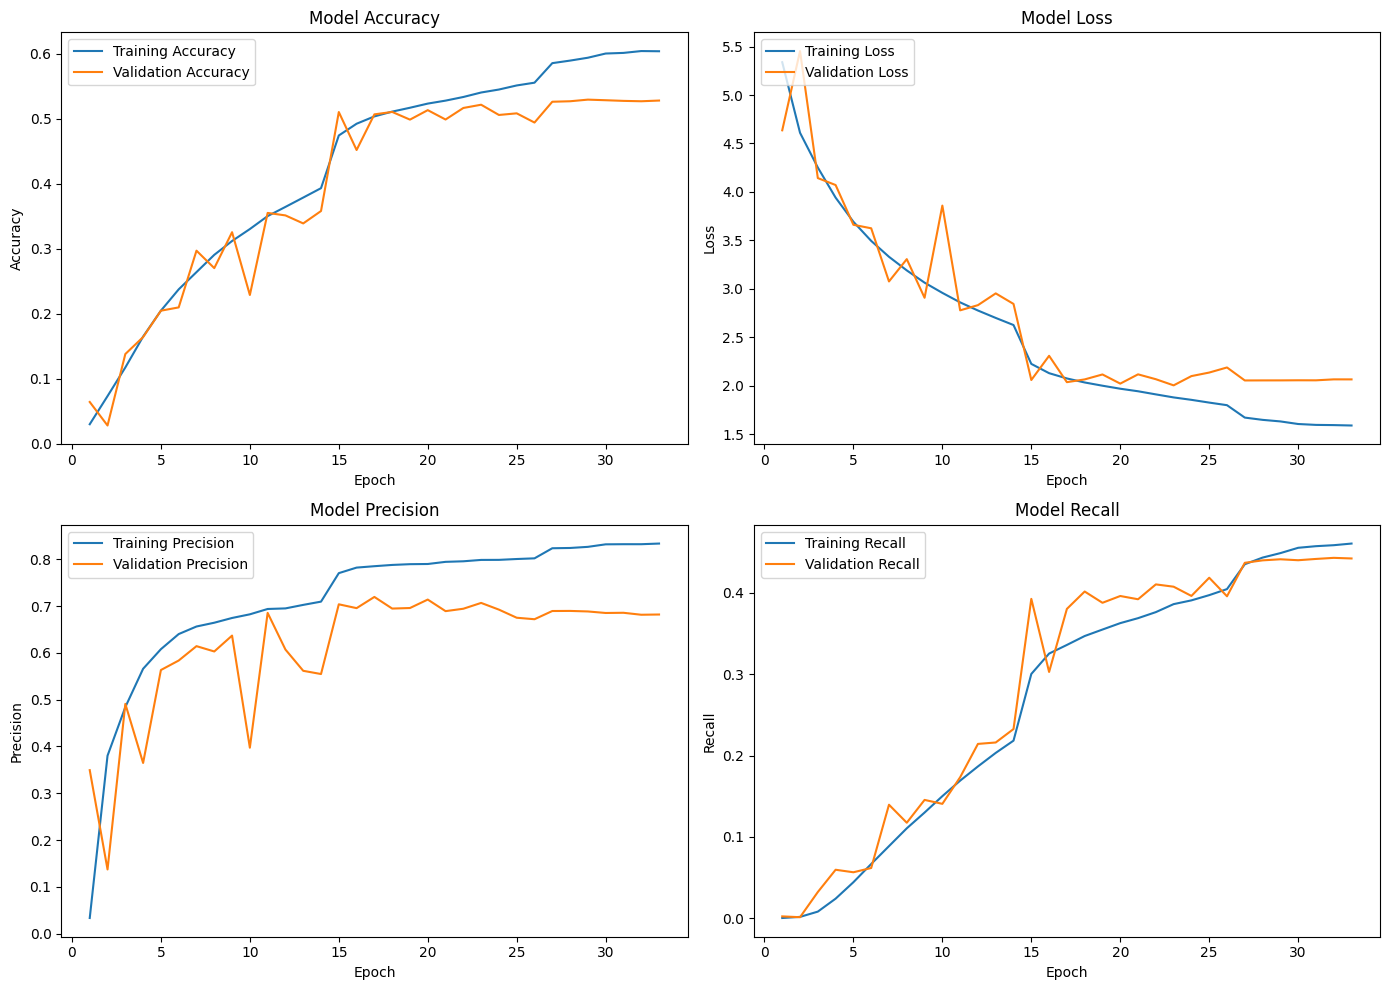

In [11]:
# Load the history from the first file
with open('/kaggle/working/Dense_Model_Data/created_NoWeights_train_history_20241130_055715.pkl', 'rb') as file:
    history1 = pickle.load(file)

# Load the history from the second file
with open('/kaggle/working/Dense_Model_Data/created_NoWeights_train_history_20241201_060008.pkl', 'rb') as file: 
    history2 = pickle.load(file)

# Combine metrics for all keys in the history
combined_history = {}
for key in history1:
    combined_history[key] = history1[key] + history2[key]

# Define combined epochs
total_epochs = len(combined_history['loss'])
epochs = np.arange(1, total_epochs + 1)

# Set up a larger figure with 2 rows and 2 columns
plt.figure(figsize=(14, 10))

# Plot training & validation accuracy
plt.subplot(2, 2, 1)
plt.plot(epochs, combined_history['accuracy'], label='Training Accuracy')
plt.plot(epochs, combined_history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

# Plot training & validation loss
plt.subplot(2, 2, 2)
plt.plot(epochs, combined_history['loss'], label='Training Loss')
plt.plot(epochs, combined_history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

# Plot training & validation precision
plt.subplot(2, 2, 3)
plt.plot(epochs, combined_history['precision'], label='Training Precision')
plt.plot(epochs, combined_history['val_precision'], label='Validation Precision')
plt.title('Model Precision')
plt.ylabel('Precision')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

# Plot training & validation recall
plt.subplot(2, 2, 4)
plt.plot(epochs, combined_history['recall'], label='Training Recall')
plt.plot(epochs, combined_history['val_recall'], label='Validation Recall')
plt.title('Model Recall')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()


In [11]:
report = classification_report(y_true, y_pred, output_dict=True)
df_report = pd.DataFrame(report).transpose()
df_report.sort_values(by='f1-score', ascending=False).head(50)

,precision,recall,f1-score,support
beignet,0.812500,0.852459,0.832000,61.0
rock_cake,0.804348,0.840909,0.822222,44.0
cheesecake,0.789474,0.833333,0.810811,54.0
oyster,0.786885,0.827586,0.806723,58.0
bruschetta,0.811321,0.741379,0.774775,58.0
boston_cream_pie,0.721311,0.830189,0.771930,53.0
tenderloin,0.709677,0.814815,0.758621,54.0
burrito,0.733333,0.771930,0.752137,57.0
french_fries,0.696970,0.807018,0.747967,57.0
beef_tartare,0.853659,0.660377,0.744681,53.0


In [12]:
df_report.sort_values(by='f1-score', ascending=True).head(50)

,precision,recall,f1-score,support
foie_gras,0.000000,0.000000,0.000000,2.0
flan,0.074074,0.047619,0.057971,42.0
schnitzel,0.500000,0.043478,0.080000,23.0
farfalle,0.173913,0.080000,0.109589,50.0
churro,0.250000,0.090909,0.133333,11.0
sukiyaki,0.800000,0.081633,0.148148,49.0
pancake,0.227273,0.119048,0.156250,42.0
falafel,0.333333,0.119048,0.175439,42.0
pate,0.184211,0.189189,0.186667,37.0
meatball,0.357143,0.147059,0.208333,34.0


In [14]:
class_list_path = '/kaggle/input/ifood-2019/ifood-2019-fgvc6/class_list.txt'

# Read the class list from the file
class_list = {}
with open(class_list_path, 'r') as file:
    for line in file:
        class_number, food_name = line.strip().split(maxsplit=1)
        class_list[int(class_number)] = food_name


data = []
for class_number, food_name in class_list.items():
    class_path = os.path.join(train_dir, str(class_number))
    if os.path.exists(class_path):
        num_images = len(os.listdir(class_path))
        data.append({"Class Number": class_number, "Food Name": food_name, "Num Images": num_images})

df = pd.DataFrame(data)

# Sort the DataFrame by number of images in descending order
sorted_df = df.sort_values(by="Num Images", ascending=False)

# Display the top 20 classes without the index
top_20 = sorted_df.head(20)
print(top_20.to_string(index=False))

 Class Number           Food Name  Num Images
          218              huitre         656
          147           casserole         636
          155              churro         635
            0             macaron         633
          117           crab_food         617
          219        chiffon_cake         614
          119         coffee_cake         612
           90             compote         611
          227          crumb_cake         610
           38                orzo         609
           12            couscous         606
          140           enchilada         604
           82          beet_salad         602
          215      barbecued_wing         602
          141             ceviche         600
          198             burrito         598
           79 macaroni_and_cheese         593
           98             lasagna         593
           57             gnocchi         593
            8            dumpling         591


                precision    recall  f1-score  support
adobo            0.170732  0.350000  0.229508     40.0
ambrosia_food    0.351351  0.309524  0.329114     42.0
apple_pie        0.688889  0.704545  0.696629     44.0
apple_turnover   0.293103  0.395349  0.336634     43.0
applesauce       0.220930  0.575758  0.319328     33.0
...                   ...       ...       ...      ...
vol_au_vent      0.421053  0.489796  0.452830     49.0
waffle           0.466667  0.625000  0.534351     56.0
welsh_rarebit    0.553191  0.565217  0.559140     46.0
wonton           0.692308  0.391304  0.500000     46.0
ziti             0.500000  0.414634  0.453333     41.0

[251 rows x 4 columns]
     Class Number         Food Name  precision    recall  f1-score  support  \
124           218            huitre   0.421053  0.444444  0.432432     54.0   
37            147         casserole   0.500000  0.342857  0.406780     35.0   
53            155            churro   0.250000  0.090909  0.133333     11.0   


/tmp/ipykernel_30/1979297036.py:25: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Num Images', y='f1-score', data=class_analysis_sorted, palette='viridis', ci=None)


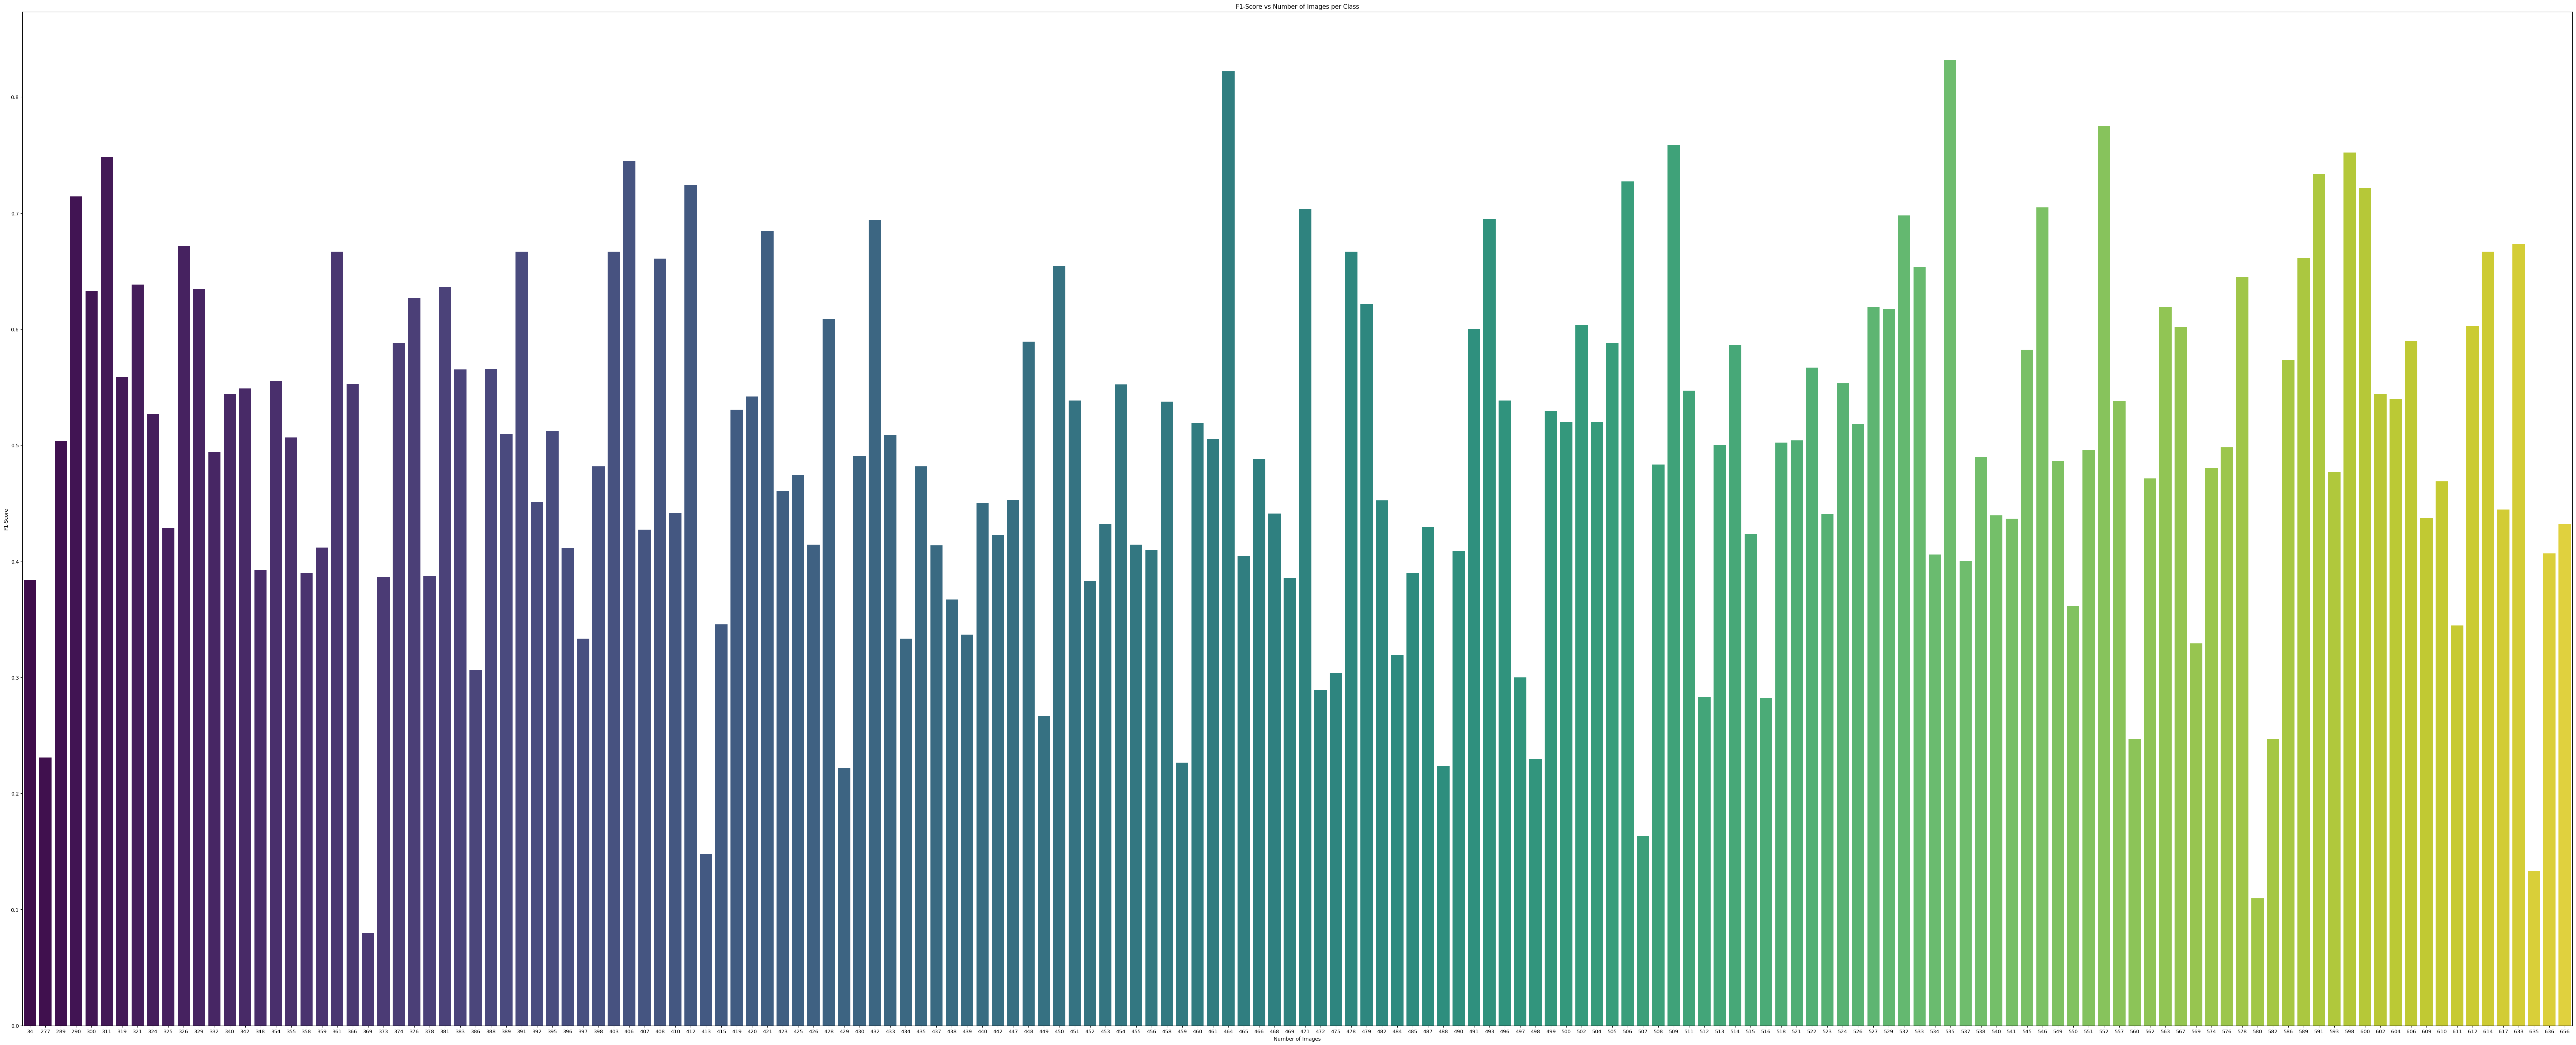

In [16]:
class_list = label_map.values()
metrics_df = df_report
metrics_df = df_report.drop(['accuracy', 'macro avg', 'weighted avg'], errors='ignore')
print(metrics_df)
metrics_df.insert(0, "Food Name", metrics_df.index)
metrics_df.reset_index(drop=True, inplace=True)

reverse_label_map = {v: k for k, v in label_map.items()}

# Create the new column "Class Number" using the reversed dictionary
metrics_df['Class Number'] = metrics_df['Food Name'].map(reverse_label_map)

metrics_df.insert(0, "Class Number", metrics_df.pop("Class Number"))

class_analysis = metrics_df.merge(df, on=['Food Name', 'Class Number'], how='left')

# Sort by F1-score and display
class_analysis_sorted = class_analysis.sort_values(by='Num Images', ascending=False)
print(class_analysis_sorted)

# Plot F1-score vs. Number of Images
plt.figure(figsize=(90, 36))
sns.barplot(x='Num Images', y='f1-score', data=class_analysis_sorted, palette='viridis', ci=None)
plt.title('F1-Score vs Number of Images per Class')
plt.xlabel('Number of Images')
plt.ylabel('F1-Score')
plt.show()